In [1]:
import custom_style; 
custom_style.style()

In [2]:
import os
import sys
if os.sys.platform == 'darwin':
    sys.path.append('/Users/j35/git/BraggEdge/python')
else:
    sys.path.append(r"C:\Users\user\Documents\GitHub\BraggEdge\python")
    sys.path.append(r"C:\Users\user\Anaconda3\envs\SNAP2016\lib\site-packages")
 
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets.widgets import interact

from pprint import pprint

import datetime
import glob
import shutil
import math
    
from neutronbraggedge.experiment_handler import *
from neutronbraggedge.braggedge import BraggEdge
from neutronbraggedge.material_handler.retrieve_material_metadata import RetrieveMaterialMetadata

from ipywidgets import widgets
#from IPython.html import widgets
from IPython.display import display

import gui_widgets
import normalization
import load_handler

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

ImportError: No module named 'pandas'

#### Load config

In [5]:
from PyQt.QtCore import QSettings
settings = QSettings()

default_dir = settings.value('default_dir')
if not(default_dir is None):
    default_dir = str(default_dir)
elif os.sys.platform == 'darwin':
    default_dir = os.path.join('/Volumes', 'My Book Thunderbolt Duo', 'IPTS', 'ResonanceImaging')
else:
    default_dir = r"C:\Data"

distance_source_detector = settings.value('distance_source_detector')
if not (distance_source_detector is None):
    distance_source_detector = float(distance_source_detector)
else:
    distance_source_detector = 15.89

detector_offset = settings.value('detector_offset')
if not (detector_offset is None):
    detector_offset = float(detector_offset)
else:
    detector_offset = 4200

ImportError: No module named 'PyQt4'

## USER INPUT

#### Select a default starting directory (optional) 

In [4]:
default_dir_widget = widgets.Text(
    description='default_dir',
    value=default_dir)
display(default_dir_widget)

#### What is the distance source-detector ?

In [5]:
distance_source_detector_widget = widgets.Text(
    description = 'dSD (m)',
    value = str(distance_source_detector))
display(distance_source_detector_widget)

#### What is the detector offset ?

In [6]:
detector_offset_widget = widgets.Text(
    description = 'detector_offset (micros)',
    value = str(detector_offset))
display(detector_offset_widget)

#### Save config

In [7]:
default_dir = default_dir_widget.value
distance_source_detector = float(distance_source_detector_widget.value)
detector_offset = float(detector_offset_widget.value)

settings.setValue('default_dir', str(default_dir))
settings.setValue('distance_source_detector', str(distance_source_detector))
settings.setValue('detector_offset', str(detector_offset))


## Loading Data

In [8]:
%gui qt

In [9]:
raw_folder = gui_widgets.gui_dname(dir = default_dir) 

list_files = glob.glob(raw_folder + '/*.fits')
if list_files == []:
    raise ValueError("No FITS file listed")

# remove from list *_SummedImg.fits fille
list_files = [file for file in list_files if not "_SummedImg.fits" in file] 

# =================================
# Automatically load and convert Time Spectra
# =================================
dir_name = os.path.dirname(list_files[0])

spectra_files_name = glob.glob(dir_name + '/*_Spectra.txt')
if spectra_files_name == []:
    print("Select Spectra File...")
    spectra_file = gui_widgets.gui_single_file(dir = default_dir)
else:
    spectra_file = spectra_files_name[0]

_tof_handler = TOF(filename = spectra_file)

_exp = Experiment(tof = _tof_handler.tof_array, 
                  distance_source_detector_m = distance_source_detector, 
                  detector_offset_micros = detector_offset)

lambda_array = _exp.lambda_array * 1e10 # to be in Angstroms
tof_array = _exp.tof_array

# =================================
# Load Data
# =================================
w = widgets.IntProgress(descrption='Loading data')
w.max = len(list_files)
display(w)

data = []
for _index, _file in enumerate(list_files):
    _image = load_handler.load_data(_file)
    data.append(_image)
    w.value = _index + 1

### Crop Region

[20, 492, 20, 492]

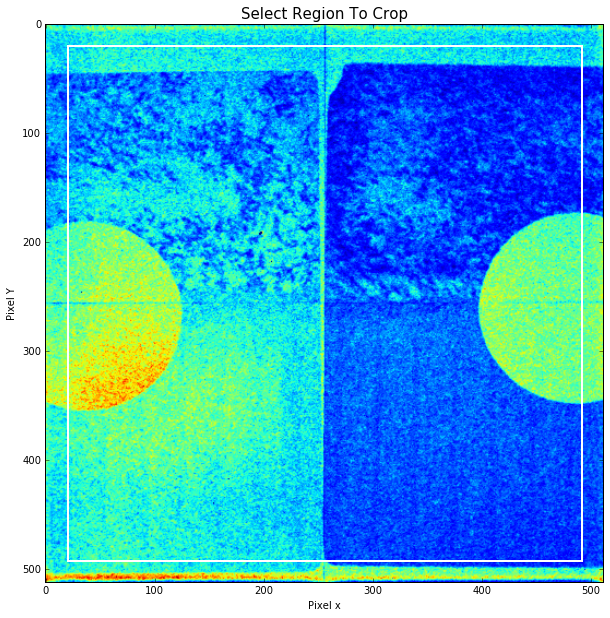

In [10]:
# =================================
# Crop Data
# =================================
[height, width] = data[0].shape

def plot_image_for_cropping(file_index, x_left, x_right, y_top, y_bottom):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Region To Crop", fontsize=15)
    ax_img.set_xlabel("Pixel x")
    ax_img.set_ylabel("Pixel Y")
 
    _rectangle = patches.Rectangle(
        (x_left, y_top),
        x_right - x_left,
        y_bottom - y_top,
        edgecolor = "white",
        linewidth = 2,
        fill = False)
    ax_img.add_patch(_rectangle)

    return [x_left, x_right, y_top, y_bottom]

number_of_files = len(list_files)
crop = interact(plot_image_for_cropping,
        file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='Image index'),
        x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=20),
        x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=width-20),
        y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=20), 
        y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=height-20))

## Loading Resonance ASCII file 

In [24]:
resonance_file = gui_widgets.gui_csv_fname(dir = default_dir)
resonance_dict = load_handler.load_csv_table_file(resonance_file)

list_items = list(resonance_dict['data'].keys())
result = widgets.Dropdown(options = list_items,
                         value = list_items[0],
                         allow_none = False,
                         sync = True,
                         help = """Select the element for which you want to plot the resonance peaks""",
                         description = "Choose an element")
display(result)

## Plot Raw vs Table Resonances 

In [32]:
def convert_ev_to_lambda(dictionary):
    new_dict = {}
    for _tag, _value in dictionary.items():
        _val1 = _value * 1e-3
        _val2 = math.sqrt(_val1)
        new_val = 9.045 / _val2
        new_dict[_tag] = new_val
    return new_dict

In [33]:
fig = tools.make_subplots(2, 1)

[x_left, x_right, y_top, y_bottom] = crop.widget.result

sum_cropped_data = []
for _data in data:
    _sum_data = np.sum(_data[y_top:y_bottom, x_left:x_right])
    sum_cropped_data.append(_sum_data)

# format resonance labels
_resonance_value = {}
_material = result.value
for _value in resonance_dict['data'][_material]:
    _tag = "{} {}ev".format(_material, _value)
    _resonance_value[_tag] = float(_value)

# convert from ev To angstroms
_resonance_value_lambda = convert_ev_to_lambda(_resonance_value)
    
trace = go.Scatter(
    x = lambda_array,
    y = sum_cropped_data,
    mode = 'markers')

trace2 = go.Scatter(
    x = tof_array,
    y = sum_cropped_data,
    mode = 'markers')

layout = go.Layout(
    width = "100%",
    height = 500,
    title = "Sum Counts vs TOF",
    xaxis = dict(
        title = "Lambda (Angstroms)"
                ),
    yaxis = dict(
        title = "Sum Counts"
                ),
    )

max_x = 6
y_off = 1

for _tag, _value in _resonance_value_lambda.items():
    if _value > max_x:
        continue
    reso_line = {"type": "line",
                'x0': _value,
                'x1': _value,
                 'yref': "paper",
                 'y0': 0,
                 'y1': 1,
                 'line': {
                    'color': 'rgb(255, 0, 0)',
                    'width': 1
        }}
    layout.shapes.append(reso_line)
    y_off = 1 - 0.25

    # add labels to plots
    _annot = dict(
                x=_value,
                y= y_off,
                text = _tag,
                yref="paper",
                font=dict(
                    family="Arial",
                    size=12,
                    color="rgb(150,50,50)"
                ),
                showarrow=True,
                arrowhead=3,
                ax=0,
                ay=-25)

    layout.annotations.append(_annot)
        
#figure = tools.make_subplots(rows=2, cols=1)
#figure.append_trace(trace, 1, 1)
#figure.append_trace(trace2, 2, 1)
#figure.layout = layout

data1 = [trace]
def plot_final_image(x_left, x_right, y_top, y_bottom):
    layout.xaxis.range = [x_left, x_right]
    layout.yaxis.range = [y_bottom, y_top]
    figure = go.Figure(data=data1, layout=layout)
    iplot(figure)

resize = interact(plot_final_image,
        x_left = widgets.FloatSlider(min=lambda_array[0], max=lambda_array[-1], 
                                     description = 'Lambda min (Angstroms)',
                                     step=0.01, value=lambda_array[0]),
        x_right = widgets.FloatSlider(min=lambda_array[0], max=lambda_array[-1], 
                                      description = 'Lambda max (Angstroms)',
                                      step=0.01, value=lambda_array[-1]),
        y_top = widgets.FloatSlider(min=np.min(sum_cropped_data), max=max(sum_cropped_data),
                                        description = 'Max Counts',
                                       step=0.01, value=np.max(sum_cropped_data)),
        y_bottom = widgets.FloatSlider(min=np.min(sum_cropped_data), max=max(sum_cropped_data),
                                        description = 'Min Counts',
                                       step=0.01, value=np.min(sum_cropped_data)))


In [34]:
print(_resonance_value)
print(_resonance_value_lambda)

{'Hf 5.892ev': 5.892, 'Hf 2.38ev': 2.38, 'Hf 7.78ev': 7.78, 'Hf 1.094ev': 1.094, 'Hf 5.68405ev': 5.68405, 'Hf 8.869ev': 8.869, 'Hf 6.571ev': 6.571}
{'Hf 5.892ev': 117.8357857497401, 'Hf 2.38ev': 185.40442394982938, 'Hf 7.78ev': 102.54601136709691, 'Hf 1.094ev': 273.46384144470824, 'Hf 5.68405ev': 119.97192474242075, 'Hf 8.869ev': 96.04422218293742, 'Hf 6.571ev': 111.58166500506292}


In [37]:
9.045/math.sqrt(5.892*1e-3)


117.8357857497401